## EECS 731 Project 5
### Adam Podgorny

In [576]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [523]:
#Sourced from https://www.kaggle.com/felixzhao/productdemandforecasting
data = pd.read_csv("Historical Product Demand.csv")

In [524]:
data['Product_Code'].value_counts()

Product_1359    16936
Product_1295    10575
Product_1378     9770
Product_0620     9428
Product_1286     8888
                ...  
Product_1912        2
Product_0465        1
Product_1703        1
Product_2099        1
Product_0853        1
Name: Product_Code, Length: 2160, dtype: int64

Since we will likely have the most available data for Product_1359, we will exclusively use that product to attempt to forecast. Because I don't think it will mean much if I try to forecast with a single sample point.

In [525]:
data = data[data['Product_Code'] == 'Product_1359']

In [526]:
data['Warehouse'].value_counts()

Whse_J    16936
Name: Warehouse, dtype: int64

Only one type of value for warehouse, so...I think we can drop that

In [527]:
data = data.drop(['Warehouse'], axis=1)
data = data.drop(['Product_Code'], axis=1)
data = data.drop(['Product_Category'], axis=1)

In [528]:
data

,Date,Order_Demand
276,2012/4/18,80000
282,2012/5/21,70000
289,2012/6/26,80000
292,2012/7/17,100000
296,2012/8/24,100000
...,...,...
1046514,2016/10/3,20000
1046515,2016/9/16,10000
1046516,2016/11/1,30000
1046517,2016/12/1,20000


Let's split those dates apart

In [529]:
data['Year'] = data['Date'].apply(lambda x: int(x.split("/")[0]))
data['Month'] = data['Date'].apply(lambda x: int(x.split("/")[1]))
data['Day'] = data['Date'].apply(lambda x: int(x.split("/")[2]))

In [530]:
data

,Date,Order_Demand,Year,Month,Day
276,2012/4/18,80000,2012,4,18
282,2012/5/21,70000,2012,5,21
289,2012/6/26,80000,2012,6,26
292,2012/7/17,100000,2012,7,17
296,2012/8/24,100000,2012,8,24
...,...,...,...,...,...
1046514,2016/10/3,20000,2016,10,3
1046515,2016/9/16,10000,2016,9,16
1046516,2016/11/1,30000,2016,11,1
1046517,2016/12/1,20000,2016,12,1


In [531]:
data['Order_Demand']

276         80000 
282         70000 
289         80000 
292        100000 
296        100000 
            ...   
1046514     20000 
1046515     10000 
1046516     30000 
1046517     20000 
1046518     20000 
Name: Order_Demand, Length: 16936, dtype: object

In [532]:
data['Order_Demand'].value_counts()

1000       2578
10000      2156
5000       1959
2000       1414
25000      1290
           ... 
234000        1
650000        1
118000        1
210000        1
144000        1
Name: Order_Demand, Length: 161, dtype: int64

In [533]:
##It appears some cleanup is in order
data['Order_Demand'] = data['Order_Demand'].apply(lambda x: x.replace("(", ''))
data['Order_Demand'] = data['Order_Demand'].apply(lambda x: x.replace(")", ''))
data['Order_Demand'] = data['Order_Demand'].apply(lambda x: float(x))

In [534]:
mean, stdev = data['Order_Demand'].mean(), data['Order_Demand'].std()

In [535]:
print("Mean: " + str(mean) + "| Stdev: " + str(stdev))

Mean: 27897.61454888994| Stdev: 69647.69264135478


In [536]:
data.corr()

,Order_Demand,Year,Month,Day
Order_Demand,1.000000,0.021436,0.004647,-0.013149
Year,0.021436,1.000000,-0.007242,-0.013686
Month,0.004647,-0.007242,1.000000,-0.041816
Day,-0.013149,-0.013686,-0.041816,1.000000


So this shouldn't suprise us, after all, this is ideally somewhat seasonal, after all, let's plot it

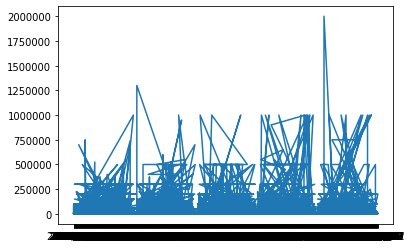

In [537]:
plt.plot(data['Date'], data['Order_Demand'])

In [538]:
plt.show()

Noticed something here...Many days have multiple entries! So let's be smart about this and group by date, then sum the rows that correspond to the same day. 

In [539]:
data = data.groupby(['Date']).sum()
data = data.reset_index()
data = data.reset_index()

In [540]:
data['Year'] = data['Date'].apply(lambda x: int(x.split("/")[0]))
data['Month'] = data['Date'].apply(lambda x: int(x.split("/")[1]))
data['Day'] = data['Date'].apply(lambda x: int(x.split("/")[2]))
data['DOY'] = data['Date'].apply(lambda x: pd.Period(x).dayofyear)
data['DOW'] = data['Date'].apply(lambda x: pd.Period(x).dayofweek)

In [541]:
data

,index,Date,Order_Demand,Year,Month,Day,DOY,DOW
0,0,2012/1/10,783000.0,2012,1,10,10,1
1,1,2012/1/11,200000.0,2012,1,11,11,2
2,2,2012/1/12,284000.0,2012,1,12,12,3
3,3,2012/1/13,532000.0,2012,1,13,13,4
4,4,2012/1/16,479000.0,2012,1,16,16,0
...,...,...,...,...,...,...,...,...
1227,1227,2016/9/6,243000.0,2016,9,6,250,1
1228,1228,2016/9/7,462000.0,2016,9,7,251,2
1229,1229,2016/9/8,288000.0,2016,9,8,252,3
1230,1230,2016/9/9,124000.0,2016,9,9,253,4


In [542]:
#plt.plot(data['index'], data['Order_Demand'])

In [543]:
d2012 = data[data['Year'] == 2012]

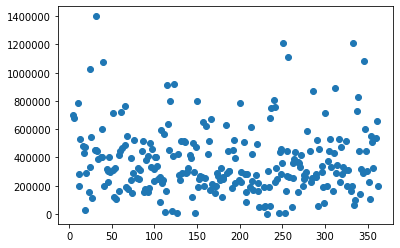

In [544]:
plt.scatter(d2012['DOY'], d2012['Order_Demand'])

Hey, look at that! We see some seasonality made far more apparent! 

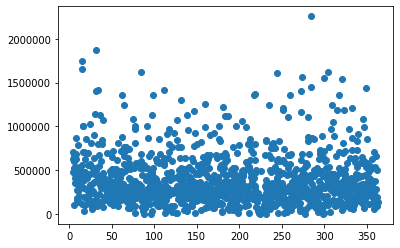

In [545]:
plt.scatter(data['DOY'], data['Order_Demand'])

A bit harder to tell here, way too crowded.

In [546]:
data.corr()

,index,Order_Demand,Year,Month,Day,DOY,DOW
index,1.000000,-0.051194,0.979759,0.011116,-0.011052,0.009704,-0.032331
Order_Demand,-0.051194,1.000000,-0.037914,-0.018885,-0.096212,-0.027071,-0.082880
Year,0.979759,-0.037914,1.000000,-0.001984,-0.006799,-0.002625,-0.032069
Month,0.011116,-0.018885,-0.001984,1.000000,-0.053979,0.996378,0.008638
Day,-0.011052,-0.096212,-0.006799,-0.053979,1.000000,0.030826,0.007029
DOY,0.009704,-0.027071,-0.002625,0.996378,0.030826,1.000000,0.009256
DOW,-0.032331,-0.082880,-0.032069,0.008638,0.007029,0.009256,1.000000


In [547]:
years = [2012, 2013, 2014, 2015, 2016]

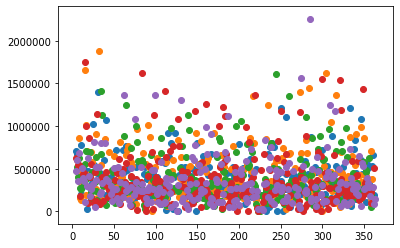

In [548]:
for i in years:
    subset = data[data['Year'] == i]
    plt.scatter(subset['DOY'], subset['Order_Demand'])

Well that is pretty and colorful

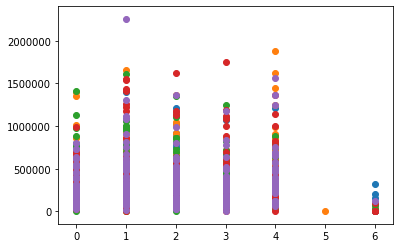

In [549]:
for i in years:
    subset = data[data['Year'] == i]
    plt.scatter(subset['DOW'], subset['Order_Demand']) ##I could drop weekends here, but there are nontrivial sales

Far less activity on weekends, it seems. That is definitely usable. Let's one hot code the weekday, so that there isn't some kind of wierd distance imposed on the day of the week. Consider here, we see that business is pretty solid throughout the workweek.

In [550]:
oh_data = pd.get_dummies(data, columns=['DOW']) 

In [551]:
oh_data

,index,Date,Order_Demand,Year,Month,Day,DOY,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,0,2012/1/10,783000.0,2012,1,10,10,0,1,0,0,0,0,0
1,1,2012/1/11,200000.0,2012,1,11,11,0,0,1,0,0,0,0
2,2,2012/1/12,284000.0,2012,1,12,12,0,0,0,1,0,0,0
3,3,2012/1/13,532000.0,2012,1,13,13,0,0,0,0,1,0,0
4,4,2012/1/16,479000.0,2012,1,16,16,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1227,2016/9/6,243000.0,2016,9,6,250,0,1,0,0,0,0,0
1228,1228,2016/9/7,462000.0,2016,9,7,251,0,0,1,0,0,0,0
1229,1229,2016/9/8,288000.0,2016,9,8,252,0,0,0,1,0,0,0
1230,1230,2016/9/9,124000.0,2016,9,9,253,0,0,0,0,1,0,0


In [552]:
features = data.drop(["Order_Demand", "Date"], axis=1)
target = data['Order_Demand']

In [553]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=1)

In [554]:
lr = LinearRegression().fit(x_train, y_train)

In [555]:
y_pred = lr.predict(x_test)
mean_squared_error(y_test, y_pred)

86556884619.6399

In [556]:
features = oh_data.drop(["Order_Demand", "Date"], axis=1)
target = oh_data['Order_Demand']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=1)
lr = LinearRegression().fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr_naive_mse = mean_squared_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

81423382268.73653

Looks like one hot helps here. But...maybe not by very much. But let's face it, the basic linear regression model isn't particularly useful right now. We need smarter approaches. Let's try to start putting some averages to each of various time features.

In [557]:
doy_means = data.groupby(['DOY']).mean()
dow_means = data.groupby(['DOW']).mean()
dom_means = data.groupby(['Day']).mean()
month_means = data.groupby(['Month']).mean()

In [558]:
dom_means

,index,Order_Demand,Year,Month,DOY,DOW
Day,,,,,,
1,630.050000,540575.000000,2014.050000,7.000000,182.975000,2.175000
2,628.925000,448400.000000,2014.000000,7.175000,189.325000,1.975000
3,629.342857,413028.571429,2013.971429,6.971429,184.114286,1.885714
4,646.026316,424657.894737,2014.052632,7.078947,188.421053,2.157895
5,613.951220,454560.975610,2013.951220,6.707317,178.243902,2.097561
6,603.465116,372651.162791,2013.930233,6.162791,162.674419,2.372093
7,635.390244,440390.243902,2014.048780,6.585366,176.414634,1.926829
8,659.047619,492690.476190,2014.119048,6.261905,167.547619,2.166667
9,631.931818,333363.636364,2014.000000,6.636364,180.000000,2.136364


In [559]:
##Note the absence of holidays etc
dom_means

,index,Order_Demand,Year,Month,DOY,DOW
Day,,,,,,
1,630.050000,540575.000000,2014.050000,7.000000,182.975000,2.175000
2,628.925000,448400.000000,2014.000000,7.175000,189.325000,1.975000
3,629.342857,413028.571429,2013.971429,6.971429,184.114286,1.885714
4,646.026316,424657.894737,2014.052632,7.078947,188.421053,2.157895
5,613.951220,454560.975610,2013.951220,6.707317,178.243902,2.097561
6,603.465116,372651.162791,2013.930233,6.162791,162.674419,2.372093
7,635.390244,440390.243902,2014.048780,6.585366,176.414634,1.926829
8,659.047619,492690.476190,2014.119048,6.261905,167.547619,2.166667
9,631.931818,333363.636364,2014.000000,6.636364,180.000000,2.136364


In [560]:
data['M_avg'] = data.apply(lambda x: month_means.loc[x['Month'],'Order_Demand'], axis=1)
data['Dow_avg'] = data.apply(lambda x: dow_means.loc[x['DOW'],'Order_Demand'], axis=1)
data['Doy_avg'] = data.apply(lambda x: doy_means.loc[x['DOY'],'Order_Demand'], axis=1)
data['Dom_avg'] = data.apply(lambda x: dom_means.loc[x['Day'],'Order_Demand'], axis=1)

In [561]:
data[['Order_Demand', 'Year', 'Month', 'DOW', 'M_avg', 'Dow_avg', 'Doy_avg', 'Dom_avg']].corr()

,Order_Demand,Year,Month,DOW,M_avg,Dow_avg,Doy_avg,Dom_avg
Order_Demand,1.000000,-0.037914,-0.018885,-0.082880,0.109763,0.222479,0.562973,0.191541
Year,-0.037914,1.000000,-0.001984,-0.032069,0.008374,0.051974,0.039257,0.014687
Month,-0.018885,-0.001984,1.000000,0.008638,-0.172051,-0.004680,-0.034907,0.035479
DOW,-0.082880,-0.032069,0.008638,1.000000,0.018861,-0.372529,-0.007146,0.007923
M_avg,0.109763,0.008374,-0.172051,0.018861,1.000000,0.016681,0.191106,-0.039781
Dow_avg,0.222479,0.051974,-0.004680,-0.372529,0.016681,1.000000,0.019671,-0.010128
Doy_avg,0.562973,0.039257,-0.034907,-0.007146,0.191106,0.019671,1.000000,0.293029
Dom_avg,0.191541,0.014687,0.035479,0.007923,-0.039781,-0.010128,0.293029,1.000000


Look at that, the day of the year average, followed by the day of week average, then the day of the month average, are pretty correlated to the Order Demand. There is definitely some better power in these derived features, then.

In [562]:
data.to_csv("product_1359.csv") ##Save for future use/easier github uploading as well as faceting

We see this similarly in the facets, both in the distribution uneven-ness and the multi-plots. That leads me to believe we may even be able to make predictions...just by going off of the daily average, then maybe invoking some pullup or pulldown from the weekly average, then the monthly average.

Let's add two more features. The day before's value, and the day of the week before's value. I am going to do this in a way that may be somewhat naive. I am going to take the previous 5 business days. For weekends without entries, this will be skipped, for those with entries, this will be factored, ideally. Let us see what we get.

In [563]:
data['day_before'] = 0

In [564]:
append_me = []
vals = data['Order_Demand'].to_list()
for x in range(len(data['Order_Demand'])):
    if (x == 0):
        append_me.append(0)
    else:
        append_me.append(vals[x-1])
    
data['day_before'] = append_me

In [565]:
m = 0
append_me = []
for x in range(len(vals)):
    t = []
    if (x < 7):
        append_me.append(vals[x])
    else:
        for y in range(1,8):
            t.append(vals[x-y])
        m = sum(t)/7.0
        append_me.append(m)

In [566]:
data['sevenday_avg'] = mean

In [567]:
data

,index,Date,Order_Demand,Year,Month,Day,DOY,DOW,M_avg,Dow_avg,Doy_avg,Dom_avg,day_before,sevenday_avg
0,0,2012/1/10,783000.0,2012,1,10,10,1,470161.290323,473569.105691,458666.666667,380380.952381,0.0,27897.614549
1,1,2012/1/11,200000.0,2012,1,11,11,2,470161.290323,394582.995951,166500.000000,376605.263158,783000.0,27897.614549
2,2,2012/1/12,284000.0,2012,1,12,12,3,470161.290323,329443.548387,396000.000000,320666.666667,200000.0,27897.614549
3,3,2012/1/13,532000.0,2012,1,13,13,4,470161.290323,391194.331984,456000.000000,381487.179487,284000.0,27897.614549
4,4,2012/1/16,479000.0,2012,1,16,16,0,470161.290323,352629.464286,798000.000000,361512.195122,532000.0,27897.614549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1227,2016/9/6,243000.0,2016,9,6,250,1,386752.475248,473569.105691,311666.666667,372651.162791,467000.0,27897.614549
1228,1228,2016/9/7,462000.0,2016,9,7,251,2,386752.475248,394582.995951,771750.000000,440390.243902,243000.0,27897.614549
1229,1229,2016/9/8,288000.0,2016,9,8,252,3,386752.475248,329443.548387,332000.000000,492690.476190,462000.0,27897.614549
1230,1230,2016/9/9,124000.0,2016,9,9,253,4,386752.475248,391194.331984,252200.000000,333363.636364,288000.0,27897.614549


In [568]:
data[['Order_Demand', 'Year', 'Month', 'DOW', 'M_avg', 'Dow_avg', 'Doy_avg', 'Dom_avg', 'day_before', 'sevenday_avg']].corr()

,Order_Demand,Year,Month,DOW,M_avg,Dow_avg,Doy_avg,Dom_avg,day_before,sevenday_avg
Order_Demand,1.000000e+00,-3.791366e-02,-1.888483e-02,-8.287977e-02,1.097632e-01,2.224787e-01,5.629731e-01,1.915411e-01,7.387118e-03,-1.325790e-16
Year,-3.791366e-02,1.000000e+00,-1.983601e-03,-3.206929e-02,8.373996e-03,5.197428e-02,3.925729e-02,1.468699e-02,-3.617835e-02,8.118737e-14
Month,-1.888483e-02,-1.983601e-03,1.000000e+00,8.638394e-03,-1.720506e-01,-4.679805e-03,-3.490740e-02,3.547871e-02,-1.286589e-02,-5.468416e-17
DOW,-8.287977e-02,-3.206929e-02,8.638394e-03,1.000000e+00,1.886125e-02,-3.725290e-01,-7.146487e-03,7.922565e-03,-2.155100e-02,-1.487126e-16
M_avg,1.097632e-01,8.373996e-03,-1.720506e-01,1.886125e-02,1.000000e+00,1.668137e-02,1.911064e-01,-3.978073e-02,1.072952e-01,-8.186755e-14
Dow_avg,2.224787e-01,5.197428e-02,-4.679805e-03,-3.725290e-01,1.668137e-02,1.000000e+00,1.967053e-02,-1.012764e-02,-1.858673e-02,4.736218e-14
Doy_avg,5.629731e-01,3.925729e-02,-3.490740e-02,-7.146487e-03,1.911064e-01,1.967053e-02,1.000000e+00,2.930285e-01,2.589893e-02,2.490116e-15
Dom_avg,1.915411e-01,1.468699e-02,3.547871e-02,7.922565e-03,-3.978073e-02,-1.012764e-02,2.930285e-01,1.000000e+00,2.468521e-02,-8.340235e-15
day_before,7.387118e-03,-3.617835e-02,-1.286589e-02,-2.155100e-02,1.072952e-01,-1.858673e-02,2.589893e-02,2.468521e-02,1.000000e+00,3.607381e-16
sevenday_avg,-1.325790e-16,8.118737e-14,-5.468416e-17,-1.487126e-16,-8.186755e-14,4.736218e-14,2.490116e-15,-8.340235e-15,3.607381e-16,1.000000e+00


Interestingly, there is very little correlation here. Maybe there is too much variance for it to work well. Ideally, maybe a spline fit or something could try to give some sense of local trajectory, but that may encounter problems in the periodicity if there are 'jumps' in the reset points. That said, maybe the average derivate at each point may have been useful? Either way, time to one-hot encode the day of week again and try to fit this with LR again, and ARIMA

In [569]:
oh_data = pd.get_dummies(data, columns=['DOW']) 
features = oh_data.drop(["Order_Demand", "Date"], axis=1)
target = oh_data['Order_Demand']
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=1)
lr = LinearRegression().fit(x_train, y_train)
y_pred = lr.predict(x_test)
lr_better_mse = mean_squared_error(y_test, y_pred)
mean_squared_error(y_test, y_pred)

58603961632.815094

Well, that is quite a bit better

In [572]:
(lr_better_mse - lr_naive_mse)/lr_naive_mse ##Quite a bit better, in fact

-0.28025635880128774

Let's try Decomposition! Thanks to https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

In [584]:
#sd = seasonal_decompose(oh_data, model='additive', freq=365

Or I would if I could debug this in time for submission. I had also tried ARIMA but then realized that I would be more time consuming than I could commit too right now to infer the model statistics from the ACF plots. Funnily enough, one of my first projects was on ACF plots, and so ARIMA is in my area of interests, I just sadly ran out of time to get to it today.

That said, the naive model versus the feature engineered model for the LR showed how powerful taking some seasonal features to bias a linear model can be. I think a weighted average could also be engineered, but that is less algorithmic and more some tests of weights.

Alternatively, a neural net could do this.

Actually, RF Regressors are fast, let's try

In [585]:
from sklearn.ensemble import RandomForestRegressor

In [586]:
rfr = RandomForestRegressor().fit(x_train, y_train)

In [589]:
rfr_pred = rfr.predict(x_test)

In [594]:
rf_mse = mean_squared_error(y_test, rfr_pred)
mean_squared_error(y_test, rfr_pred)

66505138802.16216

In [595]:
(rf_mse - lr_naive_mse)/lr_naive_mse

-0.18321817456976852

Interestingly, the linear model did a better job of the forecast. I should admit at this point I should have used holdout sets, but given how few years I had to work with, I didn't have data I felt comfortable losing, so I figured plucking random data points out may have been more acceptable than trying to form meaningful averages with just several years. If this set went back into the 70s, I'd feel far more comfortable doing that.

So this is actually the second time the LR outperformed the RF in my experience, and I think it has something to do with feature poisoning. A mutual information plot across the features may allow for some reduction, but as I understand the RF as applied here. More trees, fewer trees, or reduced feature sets m